In [1]:
import pandas as pd

# Load the uploaded CSV files for banks and GDP data
file_paths = {
    "TCB": "financial_data_TCB_filtered.csv",
    "VCB": "financial_data_VCB_filtered.csv",
    "BID": "financial_data_BID_filtered.csv",
    "MBB": "financial_data_MBB_filtered.csv",
    "GDP": "gdp_quarterly_2013_2023.csv"
}

# Read each file
data_tcb = pd.read_csv(file_paths["TCB"])
data_vcb = pd.read_csv(file_paths["VCB"])
data_bid = pd.read_csv(file_paths["BID"])
data_mbb = pd.read_csv(file_paths["MBB"])
data_gdp = pd.read_csv(file_paths["GDP"])

# Display the first few rows of each DataFrame for an initial inspection
data_tcb.head(), data_vcb.head(), data_bid.head(), data_mbb.head(), data_gdp.head()


(  Quarter-Year quarter    year    roe    roa  bookValuePerShare  \
 0      Q4-2023      Q4  2023.0  0.148  0.023            18683.0   
 1      Q3-2023      Q3  2023.0  0.146  0.024            18045.0   
 2      Q2-2023      Q2  2023.0  0.158  0.026            17383.0   
 3      Q1-2023      Q1  2023.0  0.178  0.029            16744.0   
 4      Q4-2022      Q4  2022.0  0.197  0.032            16100.0   
 
    interestMargin  badDebtPercentage  provisionOnBadDebt  equityOnTotalAsset  \
 0           0.040              0.012               1.021               0.155   
 1           0.042              0.014               0.930               0.163   
 2           0.044              0.011               1.156               0.167   
 3           0.047              0.008               1.338               0.163   
 4           0.053              0.009               1.250               0.162   
 
    ...  cancelDebt  bookValuePerShareChange  creditGrowth        Date  \
 0  ...       0.005         

In [2]:
# Convert the 'Date' columns to datetime format for each dataset
data_tcb['Date'] = pd.to_datetime(data_tcb['Date'])
data_vcb['Date'] = pd.to_datetime(data_vcb['Date'])
data_bid['Date'] = pd.to_datetime(data_bid['Date'])
data_mbb['Date'] = pd.to_datetime(data_mbb['Date'])
data_gdp['Date'] = pd.to_datetime(data_gdp['Date'])

# Merge the bank data with GDP data based on the 'Date' column
# First, merging all bank datasets into a single DataFrame
merged_data = data_gdp.copy()  # Start with GDP data

# Merging each bank's data into the main DataFrame
merged_data = merged_data.merge(data_tcb, on="Date", suffixes=('', '_TCB'))
merged_data = merged_data.merge(data_vcb, on="Date", suffixes=('', '_VCB'))
merged_data = merged_data.merge(data_bid, on="Date", suffixes=('', '_BID'))
merged_data = merged_data.merge(data_mbb, on="Date", suffixes=('', '_MBB'))

# Display the first few rows to verify the merging
merged_data.head()


,Date,Quarterly_GDP,Quarter-Year,quarter,year,roe,roa,bookValuePerShare,interestMargin,badDebtPercentage,...,payableOnEquity_MBB,cancelDebt_MBB,bookValuePerShareChange_MBB,creditGrowth_MBB,operationProfit_MBB,yearOperationProfitGrowth_MBB,quarterOperationProfitGrowth_MBB,postTaxProfit_MBB,provisionExpense_MBB,operationIncome_MBB
0,2013-09-30,1.305761e+06,Q3-2013,Q3,2013.0,-0.047,-0.004,3944.0,0.029,0.059,...,10.3,0.030,0.038,0.248,2173,0.164,0.064,447,-779,1439
1,2013-12-31,1.355982e+06,Q4-2013,Q4,2013.0,0.047,0.004,3964.0,0.030,0.037,...,10.9,0.016,0.011,0.178,1555,-0.345,-0.284,475,-318,873
2,2014-03-31,1.206944e+06,Q1-2014,Q1,2014.0,0.055,0.005,4115.0,0.030,0.046,...,10.6,0.018,0.040,0.195,1832,-0.007,0.178,636,-366,1176
3,2014-06-30,1.371527e+06,Q2-2014,Q2,2014.0,0.063,0.005,4175.0,0.031,0.041,...,10.6,0.020,0.033,0.186,2268,0.111,0.238,702,-574,1466
4,2014-09-30,1.426388e+06,Q3-2014,Q3,2014.0,0.070,0.006,4221.0,0.036,0.030,...,10.2,0.015,0.034,0.142,2057,-0.053,-0.093,579,-548,1271


In [3]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

# Select only numeric columns for exogenous variables, drop non-numeric or redundant columns
numeric_data = merged_data.select_dtypes(include=[np.number])

# Drop target (GDP) from exogenous variables
X = numeric_data.drop(columns=["Quarterly_GDP"])
y = numeric_data["Quarterly_GDP"]

# Train-test split: Using data till Q4-2021 for training, Q1-2022 onwards for testing
train_end = merged_data[merged_data["Date"] < "2022-01-01"].index.max()
X_train, X_test = X.iloc[:train_end + 1], X.iloc[train_end + 1:]
y_train, y_test = y.iloc[:train_end + 1], y.iloc[train_end + 1:]

# Fit SARIMAX model (initial parameters are placeholders)
sarimax_model = SARIMAX(y_train, exog=X_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 4))
sarimax_fit = sarimax_model.fit(disp=False)

# Forecast GDP for the test period
y_pred = sarimax_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)

# Display first few predicted values
y_pred.head()


c:\Users\Hii\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


34    2.214632e+06
35    2.556815e+06
36    2.609228e+06
37    2.899668e+06
38    2.719698e+06
Name: predicted_mean, dtype: float64

C:\Users\Hii\AppData\Local\Temp\ipykernel_11952\1798364733.py:12: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  future_dates = pd.date_range(start=last_date + pd.offsets.QuarterEnd(), periods=future_steps, freq='Q')


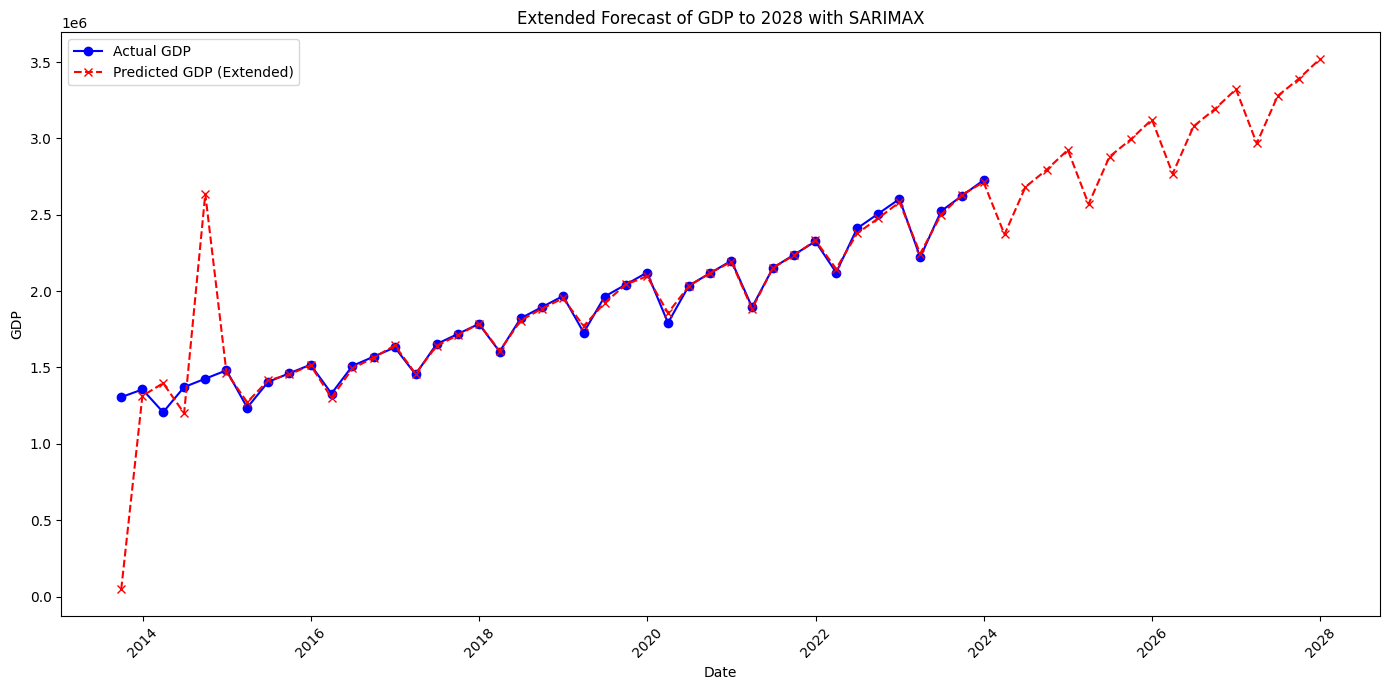

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                     Quarterly_GDP   No. Observations:                   42
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood                -421.340
Date:                           Wed, 06 Nov 2024   AIC                            878.680
Time:                                   20:02:02   BIC                            907.677
Sample:                               09-30-2013   HQIC                           888.903
                                    - 12-31-2023                                         
Covariance Type:                             opg                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
roe                     -4.349e+04   4.13e+04     -1.054      0.292   -1.24e+05    3.74e+04
roa                      9.013e+04   8.52e+04      1.057      0.290   -7.69e+04    2.57e+05
bookValuePerShare        -7.44e+04   9799.878     -7.592      0.000   -9.36e+04   -5.52e+04
interestMargin           8658.2470   2.52e+04      0.343      0.731   -4.08e+04    5.81e+04
badDebtPercentage        2.222e+04   2.54e+04      0.873      0.383   -2.76e+04    7.21e+04
provisionOnBadDebt       -475.2888   8464.338     -0.056      0.955   -1.71e+04    1.61e+04
equityOnTotalAsset       1.169e+04   2.85e+04      0.411      0.681   -4.41e+04    6.75e+04
cancelDebt              -2.767e+04   1.91e+04     -1.448      0.147   -6.51e+04    9770.723
bookValuePerShareChange  2266.8301   3636.701      0.623      0.533   -4860.973    9394.633
creditGrowth            -7393.4334   5704.438     -1.296      0.195   -1.86e+04    3787.060
operationProfit         -2724.1599   5.65e+04     -0.048      0.962   -1.13e+05    1.08e+05
postTaxProfit            9666.3973   3.18e+04      0.304      0.761   -5.27e+04     7.2e+04
provisionExpense        -3394.4273   7525.514     -0.451      0.652   -1.81e+04    1.14e+04
ar.L1                       0.6234      1.023      0.610      0.542      -1.381       2.628
ma.L1                      -0.5983      1.035     -0.578      0.563      -2.627       1.431
ar.S.L4                    -0.1430      1.195     -0.120      0.905      -2.486       2.200
ma.S.L4                     0.1776      1.155      0.154      0.878      -2.086       2.441
sigma2                   4.021e+08     19.176    2.1e+07      0.000    4.02e+08    4.02e+08
===================================================================================
Ljung-Box (L1) (Q):                   2.45   Jarque-Bera (JB):                10.69
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               1.42   Skew:                            -1.04
Prob(H) (two-sided):                  0.55   Kurtosis:                         4.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.27e+23. Standard errors may be unstable.
"""

In [9]:
# Extend predictions to 2028
# Create future exogenous values by copying the last known data (to simulate future values)
# For a real scenario, you would update exogenous variables with expected or forecasted values.
future_steps = 16  # Forecast 4 years into the future (4 quarters per year)

# Repeat last row of exogenous data for the forecast horizon
future_exog = pd.DataFrame(np.tile(gdp_data[exogenous_vars].iloc[-1], (future_steps, 1)), 
                           columns=exogenous_vars)

# Generate future dates from the last date
last_date = gdp_data.index[-1]
future_dates = pd.date_range(start=last_date + pd.offsets.QuarterEnd(), periods=future_steps, freq='Q')
future_exog.index = future_dates

# Forecast GDP to 2028
forecast_gdp = sarimax_result_gdp.predict(start=len(gdp_data), end=len(gdp_data) + future_steps - 1, exog=future_exog)

# Combine actual data and forecasts
forecast_df = pd.DataFrame({
    'Actual GDP': pd.concat([gdp_data[gdp_column], pd.Series([np.nan]*future_steps, index=future_dates)]),
    'Predicted GDP': pd.concat([gdp_data['SARIMAX_Predicted_GDP'], forecast_gdp])
})

# Plot the extended forecast
plt.figure(figsize=(14, 7))
plt.plot(forecast_df.index, forecast_df['Actual GDP'], label='Actual GDP', marker='o', color="blue")
plt.plot(forecast_df.index, forecast_df['Predicted GDP'], label='Predicted GDP (Extended)', linestyle='--', color="red", marker='x')
plt.title("Extended Forecast of GDP to 2028 with SARIMAX")
plt.xlabel("Date")
plt.ylabel("GDP")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print model summary as a textual output
sarimax_summary = sarimax_result_gdp.summary()
sarimax_summary


In [12]:
# Calculate MAPE and Accuracy based on previous values
# Assuming 'observed_gdp' and 'predicted_gdp' are defined as in the previous steps
mape = np.mean(np.abs((observed_gdp - predicted_gdp) / observed_gdp)) * 100
accuracy = 100 - mape  # Accuracy = 100% - MAPE

# Display MAPE and model accuracy
print(f"MAPE: {mape:.2f}%")
print(f"Độ chính xác của mô hình: {accuracy:.2f}%")

from sklearn.metrics import mean_squared_error

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(observed_gdp, predicted_gdp))

# Display RMSE
print(f"RMSE: {rmse:.2f}")


MAPE: 5.82%
Độ chính xác của mô hình: 94.18%
RMSE: 273200.63
